# Tuesday Tutorials: Watershed water budget mash-up

8/23/2020, Emilio

In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import contextily as cx

import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import xarray as xr
import rioxarray
import regionmask as rm

----------------
## Read Upper Yakima (HUC8 code `17030001`) HUC10 subwatersheds

Extract its bounding box, then use it (with a buffer) to query and clip gridded datasets.

We'll use the shorthand **"uy"** to refer to the Upper Yakima watershed.

**TODO:**
- Say a bit about US WBD and NHDPlus datasets, HUCs, etc
- For global applications, point to HydroSheds and HydroBASINS, including [my GHW Advanced GeoPandas notebook](https://nbviewer.jupyter.org/github/geohackweek/tutorial_contents/blob/master/vector/notebooks/geopandas_advanced.ipynb)

In [2]:
# These libraries are used only in this section
from shapely.geometry import box
import pygeoogc as geoogc
import pynhd as nhd
import pygeoutils as geoutils
import hydrodata as hd

### Read HUC08 watershed

**TODO:** I never use `uy_wduhc08` and `uy_wduhc08_gdf`, so it's best to either remove this code or place it in a "box" as a side note (FYI) at the end of this section.

In [3]:
uy_huc08code = '17030001'

In [4]:
uy_wdhuc08 = nhd.WaterData('huc08', crs='epsg:900913')

In [5]:
uy_wdhuc08

Connected to the WFS service with the following properties:
URL: https://labs.waterdata.usgs.gov/geoserver/wmadata/ows
Version: 2.0.0
Layer: wmadata:huc08
Output Format: application/json
Output CRS: epsg:900913

In [6]:
print(uy_wdhuc08.get_validnames())

['id', 'ogc_fid', 'tnmid', 'metasource', 'sourcedata', 'sourceorig', 'sourcefeat', 'loaddate', 'gnis_id', 'areaacres', 'areasqkm', 'states', 'huc8', 'name', 'shape_leng', 'shape_area', 'bbox']


- `WaterData.byid` returns a GeoDataFrame, but it has no docstring and doesn't appear to accept a filter.
- `WaterData.getfeatures_byid` returns a raw response (string), but has a full docstring and accepts a filter.

In [7]:
uy_huc08_gdf = uy_wdhuc08.byid('huc8', featureids=uy_huc08code)

### Create HUC10 subwatersheds by first reading HUC12 subwatersheds

In [8]:
uy_wdhuc12 = nhd.WaterData('huc12', crs='epsg:900913')

In [9]:
print(uy_wdhuc12.get_validnames())

['huc12', 'tohuc', 'areaacres', 'areasqkm', 'name', 'hutype', 'humod', 'states', 'noncontrib', 'bbox']


In [10]:
def wfs_getfeature_cqlfilter(wd, huccodebase):
    payload = {
        "service": "wfs",
        "request": "GetFeature",
        "version": wd.version,
        "outputFormat": wd.outformat,
        "typeName": wd.layer,
        #"srsName": "epsg:4326", # fails if I pass this epsg
        "cql_filter": f"{wd.layer} LIKE '{huccodebase}%'"  # 17030001
    }

    r = geoogc.RetrySession().get(wd.url, payload)
    
    return geoutils.json2geodf(r.json(), "epsg:4326", crs="epsg:4326")

In [11]:
uy_huc12_gdf = wfs_getfeature_cqlfilter(uy_wdhuc12, uy_huc08code)

uy_huc12_gdf.head(2)

,geometry,huc12,tohuc,areaacres,areasqkm,name,hutype,humod,states,noncontrib,bbox
0,"MULTIPOLYGON (((-120.78330 46.93610, -120.7804...",170300010602,170300010603,30687.887541,124.189475,Upper Wenas River,S,NM,WA,0,"[-120.9658, 46.846, -120.719, 46.9955]"
1,"MULTIPOLYGON (((-120.36220 46.99350, -120.3595...",170300010407,170300010409,14203.883576,57.481077,Lower Park Creek,S,"GC,CD,IT",WA,0,"[-120.4755, 46.9008, -120.2623, 46.997]"


Create `huc10` column from `huc12` codes. Ideally we'd like to have the huc10 name (but it's not available) and other huc attributes.

In [12]:
uy_huc12_gdf['huc10'] = uy_huc12_gdf.huc12.str[:-2]
cols = ['huc10', 'areasqkm', 'geometry']
uy_huc10_gdf = uy_huc12_gdf[cols].dissolve(by='huc10', aggfunc='sum', as_index=False)

len(uy_huc10_gdf)

7

In [13]:
uy_huc10_gdf.head(2)

,huc10,geometry,areasqkm
0,1703000101,"POLYGON ((-121.03840 47.26270, -121.03630 47.2...",573.245091
1,1703000102,"POLYGON ((-120.76060 47.27670, -120.75990 47.2...",534.671329


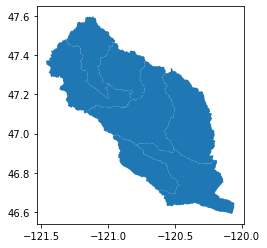

In [14]:
uy_huc10_gdf.plot();

In [15]:
uy_bbox = gpd.GeoSeries(box(*uy_huc10_gdf.total_bounds), crs=uy_huc10_gdf.crs)

These xarray slices will be used for lat-lon region clipping (via `.sel`) of xarray datasets.

In [16]:
uy_lon_slice = slice(uy_bbox.bounds.minx[0], uy_bbox.bounds.maxx[0])
uy_lat_slice = slice(uy_bbox.bounds.miny[0], uy_bbox.bounds.maxy[0])

**TODO:** 
- Look up why there are tiny "holes" (interior catchments) and whether they'll have any impacts on the watershed-aggregation processing I'll be doing.
- Consider adding a step where those holes are removed and dissolved into the enveloping polygons.

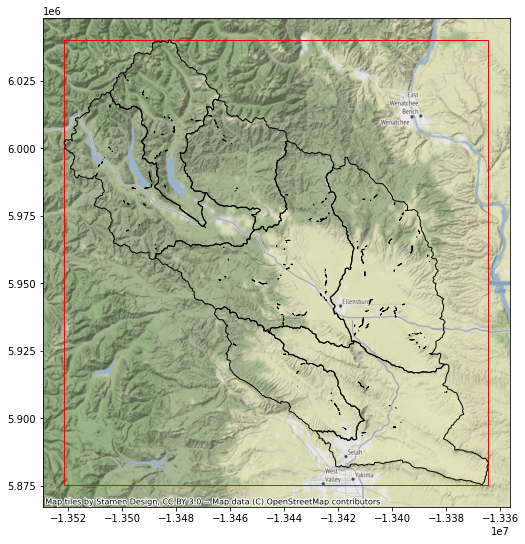

In [17]:
# project the geopandas datasets to 3857 (web mercator) so the basemap is not warped and interpolated
# and will render more quickly (actually, it still wasn't quick the first time around!)
# USE CARTOPY tile basemap functionality instead? OR IT MAY BE FASTER AND NICER TO USE FOLIUM!
ax = uy_bbox.to_crs(epsg=3857).plot(edgecolor="red", facecolor='none', figsize=(9, 9))
uy_huc10_gdf.to_crs(epsg=3857).plot(ax=ax, edgecolor='black', facecolor='none')
cx.add_basemap(ax)

## Set the time period for analysis

To be reused with every dataset.

In [18]:
date_start = '2019-1-1'
date_end = '2019-12-31'

----------------
## 1. Precipitation from DayMet

THREDDS catalog endpoint for Daymet (aggregated) was recently changed to this:
https://thredds.daac.ornl.gov/thredds-daymet/catalog/daymet-v3-agg/catalog.html?dataset=daymet-v3-agg/na.ncml

OPeNDAP access is available. It looks like you were looking at the netcdf subsetter (ncss). Go to https://thredds.daac.ornl.gov/thredds-daymet/catalog/daymet-v3-agg/catalog.html. You'll see that it's split into 3 datasets: continental north america, hawaii and puerto rico. I tested it with the continental north america dataset, https://thredds.daac.ornl.gov/thredds-daymet/catalog/daymet-v3-agg/catalog.html?dataset=daymet-v3-agg/na.ncml. Click on the opendap link to get to the opendap endpoint url, which is https://thredds.daac.ornl.gov/thredds-daymet/dodsC/daymet-v3-agg/na.ncml. Here's a code snippet that grabs one time step and a region covering Alaska:

Just be careful how much data you request. It's a very large dataset: Dimensions: time: 14600, x: 7814, y: 8075. Also, bear in mind that it's in Lambert Conformal Conic (equal area) projection, not lat-lon.

**Note that the data are in "lambert_conformal_conic", so it'll need to be reprojected to 4326 mash it up with other data.**

### Read the remote dataset (metadata only, initially)

In [19]:
daymet_opendap_url = "https://thredds.daac.ornl.gov/thredds-daymet/dodsC/daymet-v3-agg/na.ncml"
    
daymet_ds = xr.open_dataset(daymet_opendap_url)

In [20]:
daymet_ds

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 14600, x: 7814, y: 8075)
Coordinates:
  * x                        (x) float32 -4560250.0 -4559250.0 ... 3252750.0
  * y                        (y) float32 4984000.0 4983000.0 ... -3090000.0
  * time                     (time) datetime64[ns] 1980-01-01 ... 2019-12-31
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
Dimensions without coordinates: nv
Data variables:
    lambert_conformal_conic  int16 ...
    yearday                  (time) int16 ...
    time_bnds                (time, nv) datetime64[ns] ...
    dayl                     (time, y, x) float32 ...
    prcp                     (time, y, x) float32 ...
    srad                     (time, y, x) float32 ...
    swe                      (time, y, x) float32 ...
    tmax                     (time, y, x) float32 ...
    tmin                     (time, y, x) float32 ...
    vp                       (time, y, x) float32 ...
Attributes:
    start_year:        1980
    source:            Daymet Software Version 3.0
    Version_software:  Daymet Software Version 3.0
    Version_data:      Daymet Data Version 3.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    title:             Daymet: Daily Surface Weather Data on a 1-km Grid for ...
    institution:       Oak Ridge National Laboratory Distributed Active Archi...
    end_year:          2019

Examine the CRS (`grid_mapping`) variable `daymet_ds.lambert_conformal_conic` in the dataset browser, above.

### Read DayMet Precipitation for the Upper Yakima watershed bounding box

Only one year of daily data, to keep the processing reasonable.

### Get the Upper Yakima bounding box in the DayMet projection coordinates

In [21]:
daymet_ds_grid_mapping_name = 'lambert_conformal_conic'

In [22]:
# DayMet crs information is in: ds.lambert_conformal_conic
lcc_crs = CRS.from_cf(daymet_ds[daymet_ds_grid_mapping_name].attrs)

In [23]:
lcc_crs

<Projected CRS: {"$schema": "https://proj.org/schemas/v0.2/projjso ...>
Name: undefined
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: undefined
- Ellipsoid: undefined
- Prime Meridian: undefined

In [24]:
# Reproject our bounding box polygon into this new coordinate system (Lambert Conformal Conic)
uy_bbox_lcc = uy_bbox.to_crs(lcc_crs)

In [25]:
uy_lcc_bnd = uy_bbox_lcc.bounds

### Get the DayMet precipitation data for the selected XYT "cube"

The y axis coordinate values in `daymet_ds` **decrease**, not increase! That's unexpected and sub-optimal.

This statement is fast because it doesn't yet read the data from the remote THREDDS server. It uses "lazy loading" -- the dat are requested only when actually needed for a calculation or plot.

In [26]:
uy_daymet_prcp_da = daymet_ds.prcp.sel(
    time=slice(date_start, date_end),
    x=slice(uy_lcc_bnd.minx[0], uy_lcc_bnd.maxx[0]),
    y=slice(uy_lcc_bnd.maxy[0], uy_lcc_bnd.miny[0]) # note the reversed y values!
)

In [27]:
uy_daymet_prcp_da

<xarray.DataArray 'prcp' (time: 365, y: 129, x: 126)>
[5932710 values with dtype=float32]
Coordinates:
  * x        (x) float32 -1553250.0 -1552250.0 ... -1429250.0 -1428250.0
  * y        (y) float32 738000.0 737000.0 736000.0 ... 611000.0 610000.0
  * time     (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-12-31
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...
Attributes:
    long_name:     daily total precipitation
    units:         mm/day
    grid_mapping:  lambert_conformal_conic
    cell_methods:  area: mean time: sum

## Reproject to lat-lon in order to use it together with all other datasets

But will need to pre-process it so `rioxarray` can reproject the xarray dataset

In [28]:
def reproject_da_as_ds(da, from_grid_mapping_name, from_crs, to_crs):
    ds = da.to_dataset()
    ds.rio.write_crs(from_crs.to_string(), inplace=True)
    
    # maybe the drop_vars step should be done outside this function, since it's source data cleanup
    reproj_da = (
        ds
        .drop_vars(['lon', 'lat'])
        .rio.reproject(to_crs)
    )
    
    # reproj_ds = reproj_da.to_dataset()
    reproj_ds = reproj_da
    
    to_grid_mapping_name = reproj_ds[from_grid_mapping_name].attrs['grid_mapping_name']
    reproj_ds = (
        reproj_ds
        .rio.set_spatial_dims('x', 'y')
        .rio.write_crs(to_crs)
        .rename({"x": "lon", "y": "lat", from_grid_mapping_name: to_grid_mapping_name}) # this step applies only when reprojecting to lat-lon
    )
    reproj_ds.attrs['grid_mapping'] = to_grid_mapping_name
    reproj_ds[da.name].attrs['grid_mapping'] = to_grid_mapping_name
    
    return reproj_ds

In [29]:
uy_daymet_prcp_ds = reproject_da_as_ds(uy_daymet_prcp_da, daymet_ds_grid_mapping_name, lcc_crs, "epsg:4326")

In [30]:
uy_daymet_prcp_ds

<xarray.Dataset>
Dimensions:             (lat: 115, lon: 166, time: 365)
Coordinates:
  * lon                 (lon) float64 -121.8 -121.8 -121.8 ... -119.7 -119.7
  * lat                 (lat) float64 47.82 47.81 47.8 ... 46.4 46.38 46.37
  * time                (time) datetime64[ns] 2019-01-01 ... 2019-12-31
    latitude_longitude  int64 0
Data variables:
    prcp                (time, lat, lon) float32 nan nan nan nan ... nan nan nan
Attributes:
    grid_mapping:  latitude_longitude

In [31]:
def print_cellsizes(dimcoord):
    print(dimcoord.values[1] - dimcoord.values[0], dimcoord.values[-1] - dimcoord.values[-2])

In [32]:
print_cellsizes(uy_daymet_prcp_ds.lon)

0.012747575872268158 0.012747575872282368


In [33]:
print_cellsizes(uy_daymet_prcp_ds.lat)

-0.012747575872275263 -0.012747575872275263


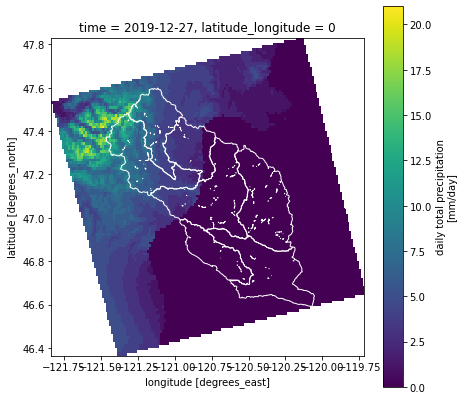

In [34]:
f, ax = plt.subplots(1, figsize=(7, 7))
uy_daymet_prcp_ds.prcp.isel(time=-5).plot(ax=ax)
uy_huc10_gdf.plot(ax=ax, edgecolor='white', facecolor='none');

Clip further, to `uy_bbox` bounding box (via `uy_lon_slice` and `uy_lat_slice`). This will make for a smaller dataset, therefore faster processing.

In [35]:
uy_daymet_prcp_ds = uy_daymet_prcp_ds.rio.clip(uy_huc10_gdf.geometry, all_touched=True)

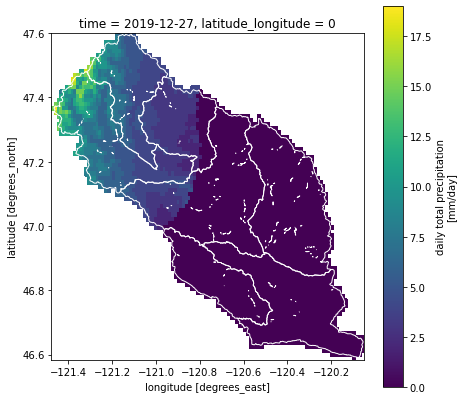

In [36]:
f, ax = plt.subplots(1, figsize=(7, 7))
uy_daymet_prcp_ds.prcp.isel(time=-5).plot(ax=ax)
uy_huc10_gdf.plot(ax=ax, edgecolor='white', facecolor='none');

----------------
## 2. Evapotranspiration from SSBo ETa

Operational Simplified Surface Energy Balance (SSEBop) model (Senay and others, 2013) for the period 2000 to present
https://cida.usgs.gov/thredds/catalog.html?dataset=cida.usgs.gov/ssebopeta/monthly
See description here: https://cida.usgs.gov/gdp/client/#!catalog/gdp/dataset/54dd5d21e4b08de9379b38b6 and https://earlywarning.usgs.gov/ssebop/modis/daily, https://earlywarning.usgs.gov/docs/USA_DAILYSSEBopETa_Oct2019.pdf

Domain: Conterminous US

In [37]:
ssebop_opendap_url = "https://cida.usgs.gov/thredds/dodsC/ssebopeta/monthly"

ssebop_ds = xr.open_dataset(ssebop_opendap_url)

In [38]:
ssebop_ds

<xarray.Dataset>
Dimensions:  (lat: 2834, lon: 6612, time: 238)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2019-10-01
  * lon      (lon) float64 -126.0 -126.0 -126.0 -126.0 ... -66.51 -66.51 -66.5
  * lat      (lat) float64 24.0 24.01 24.02 24.03 ... 49.47 49.48 49.49 49.5
Data variables:
    crs      |S64 ...
    et       (time, lat, lon) float32 ...
Attributes:
    Conventions:                     CF-1.5
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    title:                           Conterminous U.S. actual evapotranspirat...
    creator_name:                    Stefanie Kagone
    creator_email:                   skagone@contractor.usgs.gov
    summary:                         Actual ET (ETa) is produced using the op...
    cdm_data_type:                   Grid
    date_created:                    February, 2013
    date_modified:                   December, 2019
    creator_url:                     https://earlywarning.usgs.gov/ssebop/modis
    publisher_name:                  David Blodgett
    publisher_url:                   https://cida.usgs.gov/
    publisher_email:                 dblodgett@usgs.gov
    institution:                     U.S. Geological Survey
    date_issued:                     February, 2013
    project:                         WaterSMART National Water Census
    processing_level:                Refer to documentation.
    acknowledgement:                 Senay, G.B., M. Budde, J.P. Verdin, and ...
    contributors:                    Senay, G.B., S. Bohms, R. Singh, P.A. Go...
    geospatial_lat_min:              24
    geospatial_lat_max:              49.5
    geospatial_lon_min:              -126
    geospatial_lon_max:              -66.5
    time_coverage_resolution:        P1Y
    license:                         Freely available
    DODS.strlen:                     238
    DODS.dimName:                    time
    DODS_EXTRA.Unlimited_Dimension:  time

In [39]:
ssebop_ds.rio.write_crs(CRS.from_cf(ssebop_ds['crs'].attrs), inplace=True);

In [40]:
ssebop_ds.time.values[0:3]

array(['2000-01-01T00:00:00.000000000', '2000-02-01T00:00:00.000000000',
       '2000-03-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [41]:
uy_ssebop_et_ds = ssebop_ds.sel(time=slice(date_start, date_end), lon=uy_lon_slice, lat=uy_lat_slice)

uy_ssebop_et_ds

<xarray.Dataset>
Dimensions:  (lat: 112, lon: 157, time: 10)
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2019-10-01
    crs      int64 0
  * lon      (lon) float64 -121.5 -121.5 -121.4 -121.4 ... -120.1 -120.1 -120.1
  * lat      (lat) float64 46.6 46.61 46.62 46.62 ... 47.57 47.58 47.59 47.6
Data variables:
    et       (time, lat, lon) float32 ...
Attributes:
    Conventions:                     CF-1.5
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    title:                           Conterminous U.S. actual evapotranspirat...
    creator_name:                    Stefanie Kagone
    creator_email:                   skagone@contractor.usgs.gov
    summary:                         Actual ET (ETa) is produced using the op...
    cdm_data_type:                   Grid
    date_created:                    February, 2013
    date_modified:                   December, 2019
    creator_url:                     https://earlywarning.usgs.gov/ssebop/modis
    publisher_name:                  David Blodgett
    publisher_url:                   https://cida.usgs.gov/
    publisher_email:                 dblodgett@usgs.gov
    institution:                     U.S. Geological Survey
    date_issued:                     February, 2013
    project:                         WaterSMART National Water Census
    processing_level:                Refer to documentation.
    acknowledgement:                 Senay, G.B., M. Budde, J.P. Verdin, and ...
    contributors:                    Senay, G.B., S. Bohms, R. Singh, P.A. Go...
    geospatial_lat_min:              24
    geospatial_lat_max:              49.5
    geospatial_lon_min:              -126
    geospatial_lon_max:              -66.5
    time_coverage_resolution:        P1Y
    license:                         Freely available
    DODS.strlen:                     238
    DODS.dimName:                    time
    DODS_EXTRA.Unlimited_Dimension:  time
    grid_mapping:                    crs

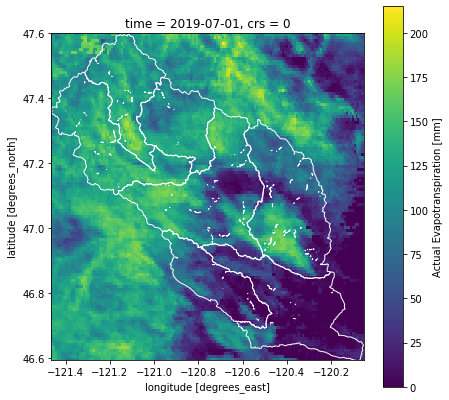

In [42]:
f, ax = plt.subplots(1, figsize=(7, 7))
uy_ssebop_et_ds.et.isel(time=6).plot(ax=ax)
uy_huc10_gdf.plot(ax=ax, edgecolor='white', facecolor='none');

----------------
## 3. Water storage change (liquid and solid)
"Ocean, Ice, and Hydrology Equivalent Water Height"

JPL GRACE and GRACE-FO Mascon Ocean, Ice, and Hydrology Equivalent Water Height Coastal Resolution Improvement (CRI) Filtered Release 06 Version 02. This dataset contains gridded monthly global water storage/height anomalies relative to a time-mean, derived from GRACE and GRACE-FO and processed at JPL using the Mascon approach (Version2/RL06). https://podaac.jpl.nasa.gov/dataset/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2

In [43]:
# Note that as of 8/23/2020, the .nc "file name" has been updated to "200204_202006" instead of "200204_202002"
# We'd probably need to crawl THREDDS (with siphon) to find the current, latest file / endpoint
# Or parse this XML file: https://podaac-opendap.jpl.nasa.gov/opendap/allData/tellus/L3/mascon/RL06/JPL/v02/CRI/netcdf/catalog.xml
grace_opendap_url = "https://podaac-opendap.jpl.nasa.gov/opendap/allData/tellus/L3/mascon/RL06/JPL/v02/CRI/netcdf/GRCTellus.JPL.200204_202006.GLO.RL06M.MSCNv02CRI.nc"

grace_ds = xr.open_dataset(grace_opendap_url)

In [44]:
grace_ds

<xarray.Dataset>
Dimensions:        (bounds: 2, lat: 360, lon: 720, time: 186)
Coordinates:
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2020-06-16
Dimensions without coordinates: bounds
Data variables:
    lat_bounds     (lat, bounds) float64 ...
    lon_bounds     (lon, bounds) float64 ...
    time_bounds    (time, bounds) datetime64[ns] ...
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
Attributes:
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    platform:                      GRACE and GRACE-FO
    institution:                   NASA/JPL
    creator_name:                  David Wiese
    creator_email:                 grace@podaac.jpl.nasa.gov
    creator_url:                   https://grace.jpl.nasa.gov
    creator_type:                  group
    creator_institution:           NASA/JPL
    publisher_name:                Physical Oceanography Distributed Active A...
    publisher_email:               podaac@jpl.nasa.gov
    publisher_url:                 https://podaac.jpl.nasa.gov
    publisher_type:                group
    publisher_institution:         NASA/JPL
    project:                       NASA Gravity Recovery and Climate Experime...
    program:                       NASA Earth Science System Pathfinder and N...
    id:                            10.5067/TEMSC-3JC62
    naming_authority:              org.doi.dx
    source:                        GRACE and GRACE-FO JPL RL06Mv2-CRI
    processing_level:              2 and 3
    acknowledgement:               GRACE is a joint mission of NASA (USA) and...
    license:                       https://science.nasa.gov/earth-science/ear...
    product_version:               v2.0
    time_epoch:                    2002-01-01T00:00:00Z
    time_coverage_start:           2002-04-16T00:00:00Z
    time_coverage_end:             2020-06-16T23:59:59Z
    geospatial_lat_min:            -89.75
    geospatial_lat_max:            89.75
    geospatial_lat_units:          degrees_north
    geospatial_lat_resolution:     0.5 degree grid; however the native resolu...
    geospatial_lon_min:            0.25
    geospatial_lon_max:            359.75
    geospatial_lon_units:          degrees_east
    geospatial_lon_resolution:     0.5 degree grid; however the native resolu...
    time_mean_removed:             2004.000 to 2009.999
    months_missing:                2002-06;2002-07;2003-06;2011-01;2011-06;20...
    postprocess_1:                  OCEAN_ATMOSPHERE_DEALIAS_MODEL (GAD), MON...
    postprocess_2:                 Water density used to convert to equivalen...
    postprocess_3:                 Coastline Resolution Improvement (CRI) fil...
    GIA_removed:                   ICE6G-D; Peltier, W. R., D. F. Argus, and ...
    geocenter_correction:          We use a version of TN-13 based on the JPL...
    C_20_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    d

In [45]:
grace_ds.lon.values.min(), grace_ds.lon.values.max()

(0.25, 359.75)

**NOTE:**
- `lon` values are 0 - 360 (starting from the anti-meridian, "-180") rather than -180 to 180 as the previous datasets! 
- We'll need to add an offset in the lon slice specification.
- Actually, we'll also need to restructure / shift the xarray dataset to make it work with the region mask and gdf overlays!

In [46]:
uy_grace_lwe_thickness_ds = grace_ds.sel(
    time=slice(date_start, date_end), 
    lon=slice(360 + uy_bbox.bounds.minx[0] - 0.5, 360 + uy_bbox.bounds.maxx[0] + 0.5), 
    lat=slice(uy_bbox.bounds.miny[0] - 0.5, uy_bbox.bounds.maxy[0] + 0.5), 
)

uy_grace_lwe_thickness_ds

<xarray.Dataset>
Dimensions:        (bounds: 2, lat: 4, lon: 5, time: 12)
Coordinates:
  * lon            (lon) float64 238.2 238.8 239.2 239.8 240.2
  * lat            (lat) float64 46.25 46.75 47.25 47.75
  * time           (time) datetime64[ns] 2019-01-16T12:00:00 ... 2019-12-16T1...
Dimensions without coordinates: bounds
Data variables:
    lat_bounds     (lat, bounds) float64 46.0 46.5 46.5 47.0 47.0 47.5 47.5 48.0
    lon_bounds     (lon, bounds) float64 238.0 238.5 238.5 ... 240.0 240.0 240.5
    time_bounds    (time, bounds) datetime64[ns] 2019-01-01 ... 2019-12-31T23...
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
Attributes:
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    platform:                      GRACE and GRACE-FO
    institution:                   NASA/JPL
    creator_name:                  David Wiese
    creator_email:                 grace@podaac.jpl.nasa.gov
    creator_url:                   https://grace.jpl.nasa.gov
    creator_type:                  group
    creator_institution:           NASA/JPL
    publisher_name:                Physical Oceanography Distributed Active A...
    publisher_email:               podaac@jpl.nasa.gov
    publisher_url:                 https://podaac.jpl.nasa.gov
    publisher_type:                group
    publisher_institution:         NASA/JPL
    project:                       NASA Gravity Recovery and Climate Experime...
    program:                       NASA Earth Science System Pathfinder and N...
    id:                            10.5067/TEMSC-3JC62
    naming_authority:              org.doi.dx
    source:                        GRACE and GRACE-FO JPL RL06Mv2-CRI
    processing_level:              2 and 3
    acknowledgement:               GRACE is a joint mission of NASA (USA) and...
    license:                       https://science.nasa.gov/earth-science/ear...
    product_version:               v2.0
    time_epoch:                    2002-01-01T00:00:00Z
    time_coverage_start:           2002-04-16T00:00:00Z
    time_coverage_end:             2020-06-16T23:59:59Z
    geospatial_lat_min:            -89.75
    geospatial_lat_max:            89.75
    geospatial_lat_units:          degrees_north
    geospatial_lat_resolution:     0.5 degree grid; however the native resolu...
    geospatial_lon_min:            0.25
    geospatial_lon_max:            359.75
    geospatial_lon_units:          degrees_east
    geospatial_lon_resolution:     0.5 degree grid; however the native resolu...
    time_mean_removed:             2004.000 to 2009.999
    months_missing:                2002-06;2002-07;2003-06;2011-01;2011-06;20...
    postprocess_1:                  OCEAN_ATMOSPHERE_DEALIAS_MODEL (GAD), MON...
    postprocess_2:                 Water density used to convert to equivalen...
    postprocess_3:                 Coastline Resolution Improvement (CRI) fil...
    GIA_removed:                   ICE6G-D; Peltier, W. R., D. F. Argus, and ...
    geocenter_correction:          We use a version of TN-13 based on the JPL...
    C_20_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_

In [47]:
uy_grace_lwe_thickness_ds.coords['lon'] = (uy_grace_lwe_thickness_ds.coords['lon'] + 180) % 360 - 180
uy_grace_lwe_thickness_ds = uy_grace_lwe_thickness_ds.sortby(uy_grace_lwe_thickness_ds.lon)

In [48]:
uy_grace_lwe_thickness_ds

<xarray.Dataset>
Dimensions:        (bounds: 2, lat: 4, lon: 5, time: 12)
Coordinates:
  * lon            (lon) float64 -121.8 -121.2 -120.8 -120.2 -119.8
  * lat            (lat) float64 46.25 46.75 47.25 47.75
  * time           (time) datetime64[ns] 2019-01-16T12:00:00 ... 2019-12-16T1...
Dimensions without coordinates: bounds
Data variables:
    lat_bounds     (lat, bounds) float64 46.0 46.5 46.5 47.0 47.0 47.5 47.5 48.0
    lon_bounds     (lon, bounds) float64 238.0 238.5 238.5 ... 240.0 240.0 240.5
    time_bounds    (time, bounds) datetime64[ns] 2019-01-01 ... 2019-12-31T23...
    lwe_thickness  (time, lat, lon) float64 5.503 5.503 5.503 ... -12.95 -12.95
    uncertainty    (time, lat, lon) float64 2.724 2.724 2.724 ... 2.769 2.769
Attributes:
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    platform:                      GRACE and GRACE-FO
    institution:                   NASA/JPL
    creator_name:                  David Wiese
    creator_email:                 grace@podaac.jpl.nasa.gov
    creator_url:                   https://grace.jpl.nasa.gov
    creator_type:                  group
    creator_institution:           NASA/JPL
    publisher_name:                Physical Oceanography Distributed Active A...
    publisher_email:               podaac@jpl.nasa.gov
    publisher_url:                 https://podaac.jpl.nasa.gov
    publisher_type:                group
    publisher_institution:         NASA/JPL
    project:                       NASA Gravity Recovery and Climate Experime...
    program:                       NASA Earth Science System Pathfinder and N...
    id:                            10.5067/TEMSC-3JC62
    naming_authority:              org.doi.dx
    source:                        GRACE and GRACE-FO JPL RL06Mv2-CRI
    processing_level:              2 and 3
    acknowledgement:               GRACE is a joint mission of NASA (USA) and...
    license:                       https://science.nasa.gov/earth-science/ear...
    product_version:               v2.0
    time_epoch:                    2002-01-01T00:00:00Z
    time_coverage_start:           2002-04-16T00:00:00Z
    time_coverage_end:             2020-06-16T23:59:59Z
    geospatial_lat_min:            -89.75
    geospatial_lat_max:            89.75
    geospatial_lat_units:          degrees_north
    geospatial_lat_resolution:     0.5 degree grid; however the native resolu...
    geospatial_lon_min:            0.25
    geospatial_lon_max:            359.75
    geospatial_lon_units:          degrees_east
    geospatial_lon_resolution:     0.5 degree grid; however the native resolu...
    time_mean_removed:             2004.000 to 2009.999
    months_missing:                2002-06;2002-07;2003-06;2011-01;2011-06;20...
    postprocess_1:                  OCEAN_ATMOSPHERE_DEALIAS_MODEL (GAD), MON...
    postprocess_2:                 Water density used to convert to equivalen...
    postprocess_3:                 Coastline Resolution Improvement (CRI) fil...
    GIA_removed:                   ICE6G-D; Peltier, W. R., D. F. Argus, and ...
    geocenter_correction:          We use a version of TN-13 based on the JPL...
    C_20_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Wa

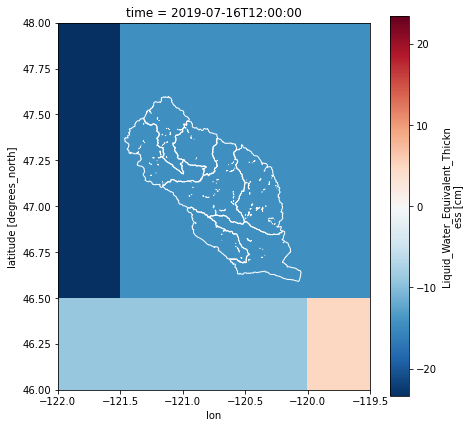

In [49]:
f, ax = plt.subplots(1, figsize=(7, 7))
uy_grace_lwe_thickness_ds.lwe_thickness.isel(time=6).plot(ax=ax)
uy_huc10_gdf.plot(ax=ax, edgecolor='white', facecolor='none');

----------------
## Use regionmask to generate huc10 regions, mask, and time series averages

https://regionmask.readthedocs.io

**NOTES ABOUT REGIONMASK:**
- [regionmask assumes data is in lat/ lon format](https://github.com/mathause/regionmask/issues/151) !!
- https://regionmask.readthedocs.io/en/stable/notebooks/mask_3D.html

### Set up regions

In [50]:
uy_huc10_regions = rm.from_geopandas(
    uy_huc10_gdf, names="huc10", name="huc10"
)

In [51]:
uy_huc10_regions

<regionmask.Regions>
Name:     huc10

Regions:
 0  r0  1703000101
 1  r1  1703000102
 2  r2  1703000103
 3  r3  1703000104
 4  r4  1703000105
 5  r5  1703000106
 6  r6  1703000107

[7 regions]

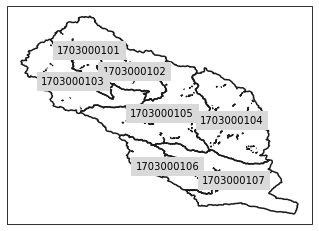

In [52]:
uy_huc10_regions.plot(label="name");

### huc10-level time series generation

In [53]:
def generate_huc10_ts(regions, ds, dsvarname):
    mask3d = regions.mask_3D(ds, drop=False)

    # But note that latitude weighting is mostly unnecessary for this small geographical extent
    weights = np.cos(np.deg2rad(ds.lat))
    regions_ts = ds[dsvarname].weighted(mask3d * weights).mean(dim=("lat", "lon"))
    # Assign dataarray name, and variable long name and units to region_ts, from ds[dsvarname]
    regions_ts.name = dsvarname
    regions_ts.attrs['long_name'] = ds[dsvarname].attrs['long_name']
    regions_ts.attrs['units'] = ds[dsvarname].attrs['units']
    
    return regions_ts

### Precipitation

In [54]:
daymet_prcp_regions_ts_daily = generate_huc10_ts(uy_huc10_regions, uy_daymet_prcp_ds, 'prcp')

In [55]:
daymet_prcp_regions_ts_daily

<xarray.DataArray 'prcp' (time: 365, region: 7)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 4.13487474,  3.69767824,  0.        , ...,  0.79492008,
         0.        ,  0.        ],
       [27.0085389 , 13.06133555, 20.63811275, ...,  4.82634672,
         1.02026616,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.06492692,
         0.        ,  0.        ],
       [47.26634023, 26.87954212, 34.5518203 , ..., 14.93272007,
         0.4512641 ,  0.        ]])
Coordinates:
  * time                (time) datetime64[ns] 2019-01-01 ... 2019-12-31
    latitude_longitude  int64 0
  * region              (region) int64 0 1 2 3 4 5 6
    abbrevs             (region) <U2 'r0' 'r1' 'r2' 'r3' 'r4' 'r5' 'r6'
    names               (region) <U10 '1703000101' '1703000102' ... '1703000107'
Attributes:
    long_name:  daily total precipitation
    units:      mm/day

Aggregate (sum) from daily to monthly resolution. Update the variable attributes on the new datarray, to reflect the monthly resolution.

In [56]:
daymet_prcp_regions_ts = daymet_prcp_regions_ts_daily.resample(time='1M').sum()
daymet_prcp_regions_ts.attrs['long_name'] = 'monthly total precipitation'
daymet_prcp_regions_ts.attrs['units'] = 'mm/month'

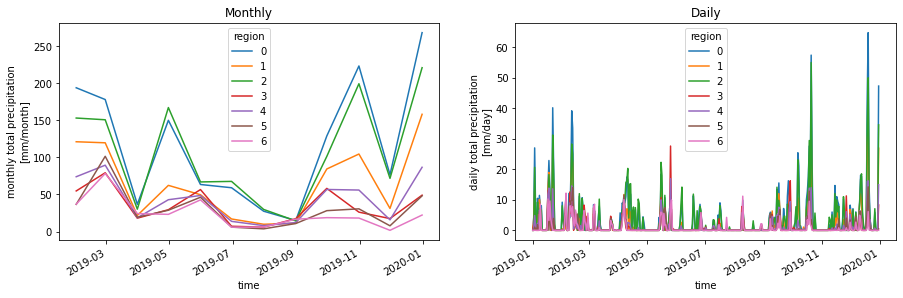

In [57]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4))
daymet_prcp_regions_ts.plot(ax=ax1, hue="region")
ax1.set_title('Monthly')
daymet_prcp_regions_ts_daily.plot(ax=ax2, hue="region")
ax2.set_title('Daily');

### Evapotranspiration

In [58]:
ssebop_et_regions_ts = generate_huc10_ts(uy_huc10_regions, uy_ssebop_et_ds, 'et')

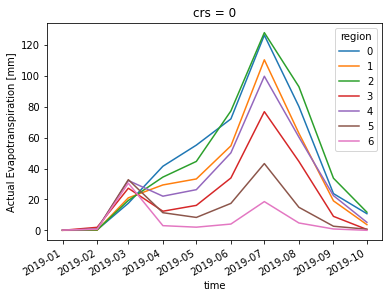

In [59]:
ssebop_et_regions_ts.plot(hue="region");

### Water storage change

In [60]:
grace_lwe_thickness_regions_ts = generate_huc10_ts(uy_huc10_regions, uy_grace_lwe_thickness_ds, 'lwe_thickness')

In [61]:
grace_lwe_thickness_regions_ts

<xarray.DataArray 'lwe_thickness' (time: 12, region: 7)>
array([[         nan,   1.59485978,   1.59485978,          nan,
                 nan,          nan,   1.59485978],
       [         nan,   1.18037628,   1.18037628,          nan,
                 nan,          nan,   1.18037628],
       [         nan,   1.83940339,   1.83940339,          nan,
                 nan,          nan,   1.83940339],
       [         nan,   0.24861455,   0.24861455,          nan,
                 nan,          nan,   0.24861455],
       [         nan,  -2.71392636,  -2.71392636,          nan,
                 nan,          nan,  -2.71392636],
       [         nan, -10.81192404, -10.81192404,          nan,
                 nan,          nan, -10.81192404],
       [         nan, -14.33497336, -14.33497336,          nan,
                 nan,          nan, -14.33497336],
       [         nan, -21.78958417, -21.78958417,          nan,
                 nan,          nan, -21.78958417],
       [         nan, -24.75441002, -24.75441002,          nan,
                 nan,          nan, -24.75441002],
       [         nan, -23.93475268, -23.93475268,          nan,
                 nan,          nan, -23.93475268],
       [         nan, -20.50932318, -20.50932318,          nan,
                 nan,          nan, -20.50932318],
       [         nan, -12.94668441, -12.94668441,          nan,
                 nan,          nan, -12.94668441]])
Coordinates:
  * time     (time) datetime64[ns] 2019-01-16T12:00:00 ... 2019-12-16T12:00:00
  * region   (region) int64 0 1 2 3 4 5 6
    abbrevs  (region) <U2 'r0' 'r1' 'r2' 'r3' 'r4' 'r5' 'r6'
    names    (region) <U10 '1703000101' '1703000102' ... '1703000107'
Attributes:
    long_name:  Liquid_Water_Equivalent_Thickness
    units:      cm

Change units to mm, and update units attribute accordingly

In [62]:
grace_lwe_thickness_regions_ts *= 10
grace_lwe_thickness_regions_ts.attrs['units'] = 'mm/month'

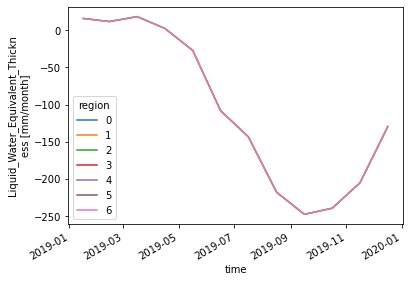

In [63]:
grace_lwe_thickness_regions_ts.plot(hue="region");

Because the cells are so coarse, a single cell spans the whole Upper Yakima and the behavior of the sub-watersheds is identical at that resolution.

----------------
## All three water budget elements

For clarity and comparability, set sub-plot titles and set a common y-axis value range; for wate storage change, the ymin and ymax values are different, but the range is still the same, 275 mm.

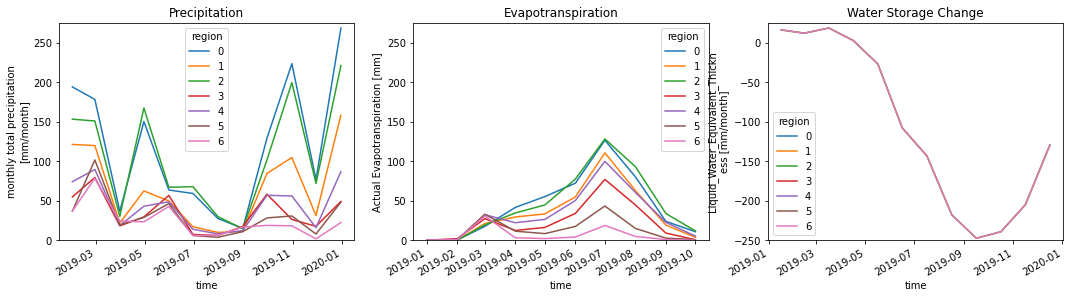

In [64]:
f, ax = plt.subplots(ncols=3, figsize=(18, 4))
daymet_prcp_regions_ts.plot(ax=ax[0], hue="region")
ax[0].set_title('Precipitation')
ax[0].set_ylim(0, 275)
ssebop_et_regions_ts.plot(ax=ax[1], hue="region")
ax[1].set_title('Evapotranspiration')
ax[1].set_ylim(0, 275)
grace_lwe_thickness_regions_ts.plot(ax=ax[2], hue="region")
ax[2].set_title('Water Storage Change')
ax[2].set_ylim(-250, 25);

----------------
## NWIS river discharge at Upper Yakima outlet

- Use ulmo. Convert to monthly. Convert to "mm" based on watershed area.
- Will need generate the UY-wide PPT and ET from the huc10-level values i currently have

----------------
## Package versions
It's useful to have this reference for reproducibility.

In [65]:
pd.__version__, gpd.__version__, xr.__version__, rioxarray.__version__, rm.__version__, hd.__version__

('1.1.0', '0.8.1', '0.16.0', '0.0.31', '0.6.1', '0.7.2')